<img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/horizontal-primary-light.png" alt="he-black-box" width="600"/>


# Homomorphic Encryption using Duet: Data Owner
## Tutorial 2: Encrypted image evaluation


Welcome!
This tutorial will show you how to evaluate Encrypted images using Duet and TenSEAL. This notebook illustrates the Data Owner view on the operations.

We recommend going through Tutorial 0 and 1 before trying this one.

### Setup

All modules are imported here, make sure everything is installed by running the cell below.

In [1]:
import os
import requests

import syft as sy
import tenseal as ts
from torchvision import transforms
from random import randint
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import torch
from syft.grid.client.client import connect
from syft.grid.client.grid_connection import GridHTTPConnection
from syft.core.node.domain.client import DomainClient
sy.load("tenseal")

## Connect to PyGrid

Connect to PyGrid Domain server.

In [2]:
client = connect(
    url="http://localhost:5000", # Domain Address
    credentials={"email":"admin@email.com", "password":"pwd123"},
    conn_type= GridHTTPConnection, # HTTP Connection Protocol
    client_type=DomainClient) # Domain Client type

### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 1 : Now STOP and run the Data Scientist notebook until the same checkpoint.

### Data Owner helpers

In [3]:
# Create the TenSEAL security context
def create_ctx():
    """Helper for creating the CKKS context.
    CKKS params:
        - Polynomial degree: 8192.
        - Coefficient modulus size: [40, 21, 21, 21, 21, 21, 21, 40].
        - Scale: 2 ** 21.
        - The setup requires the Galois keys for evaluating the convolutions.
    """
    poly_mod_degree = 8192
    coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
    ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    ctx.global_scale = 2 ** 21
    ctx.generate_galois_keys()
    return ctx

def download_images():
    try:
        os.mkdir("data/mnist-samples")
    except BaseException as e:
        pass

    url = "https://raw.githubusercontent.com/OpenMined/TenSEAL/master/tutorials/data/mnist-samples/img_{}.jpg"
    path = "data/mnist-samples/img_{}.jpg"
    
    for idx in range(6):
        img_url = url.format(idx)
        img_path = path.format(idx)
        r = requests.get(img_url)

        with open(img_path, 'wb') as f:
            f.write(r.content)
    
# Sample an image
def load_input():
    download_images()
    
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )
    idx = randint(1, 5)
    img_name = "data/mnist-samples/img_{}.jpg".format(idx)
    img = Image.open(img_name)
    return transform(img).view(28, 28).tolist(), img

# Helper for encoding the image
def prepare_input(ctx, plain_input):
    enc_input, windows_nb = ts.im2col_encoding(ctx, plain_input, 7, 7, 3)
    assert windows_nb == 64
    return enc_input


### Prepare the context

In [4]:
context = create_ctx()

### Sample and encrypt an image

Encrypted image  <tenseal.tensors.ckksvector.CKKSVector object at 0x7f80db007220>
Original image 


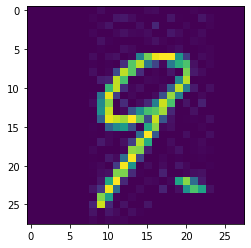

In [5]:
image, orig = load_input()

encrypted_image = prepare_input(context, image)

print("Encrypted image ", encrypted_image)
print("Original image ")
imshow(np.asarray(orig))

In [6]:
ctx_ptr = context.send(client, pointable=True, tags=["context"])
enc_image_ptr = encrypted_image.send(client, pointable=True, tags=["enc_image"])

In [7]:
client.store.pandas

,ID,Tags,Description,object_type
0,<UID: 8ed84653b176476eae9e2a8586d08f8e>,[context],,<class 'tenseal.enc_context.Context'>
1,<UID: 620901d47e4241218b756a9daf47e33d>,[enc_image],,<class 'tenseal.tensors.ckksvector.CKKSVector'>


### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 2 : Now STOP and run the Data Scientist notebook until the same checkpoint.

### Approve the requests

In [8]:
client.requests.pandas

,Requested Object's tags,Reason,Request ID,Requested Object's ID,Requested Object's type
0,[context],I would like to get the context,<UID: 842e3e7bf1d042ccaad6e77800a101fb>,<UID: 8ed84653b176476eae9e2a8586d08f8e>,<class 'tenseal.enc_context.Context'>
1,[enc_image],I would like to get encrypted evaluation image,<UID: 9e75e93e11d64414a32b7f9431efbeda>,<UID: 620901d47e4241218b756a9daf47e33d>,<class 'tenseal.tensors.ckksvector.CKKSVector'>


In [9]:
client.requests[0].accept()
client.requests[0].accept()

In [10]:
client.requests.pandas

""


### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 3 : Now STOP and run the Data Scientist notebook until the same checkpoint.

###  Retrieve and decrypt the evaluation result

In [11]:
result = client.store["result"].get(delete_obj=False)
result.link_context(context)

result = result.decrypt()

### Run the activation and retrieve the label

In [12]:
probs = torch.softmax(torch.tensor(result), 0)
label_max = torch.argmax(probs)

print("Maximum probability for label {}".format(label_max))

Maximum probability for label 9


### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 4 : Well done!

# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star PySyft and TenSEAL on GitHub

The easiest way to help our community is just by starring the Repos! This helps raise awareness of the cool tools we're building.

- [Star PySyft](https://github.com/OpenMined/PySyft)
- [Star TenSEAL](https://github.com/OpenMined/TenSEAL)

### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at [http://slack.openmined.org](http://slack.openmined.org). #lib_tenseal and #code_tenseal are the main channels for the TenSEAL project.

### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

[OpenMined's Open Collective Page](https://opencollective.com/openmined)